In [ ]:
!pip install -q torch torchvision timm scikit-learn umap-learn pandas seaborn matplotlib opencv-python tqdm gTTS folium plotly grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.8 MB/s eta 0:00:00


In [ ]:
# =====================================================
# Block 1 : Environment & Library Setup
# =====================================================
!nvidia-smi
!pip install -q torch torchvision timm scikit-learn umap-learn pandas seaborn matplotlib opencv-python tqdm gTTS folium plotly grad-cam

import os, random, torch, timm, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import warnings; warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
RAW_DATASET_DIR = "/content/drive/MyDrive/Dataset"
IMG_SIZE = 224
torch.backends.cudnn.benchmark = True


Mon Nov  3 14:11:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Total images found: 2372


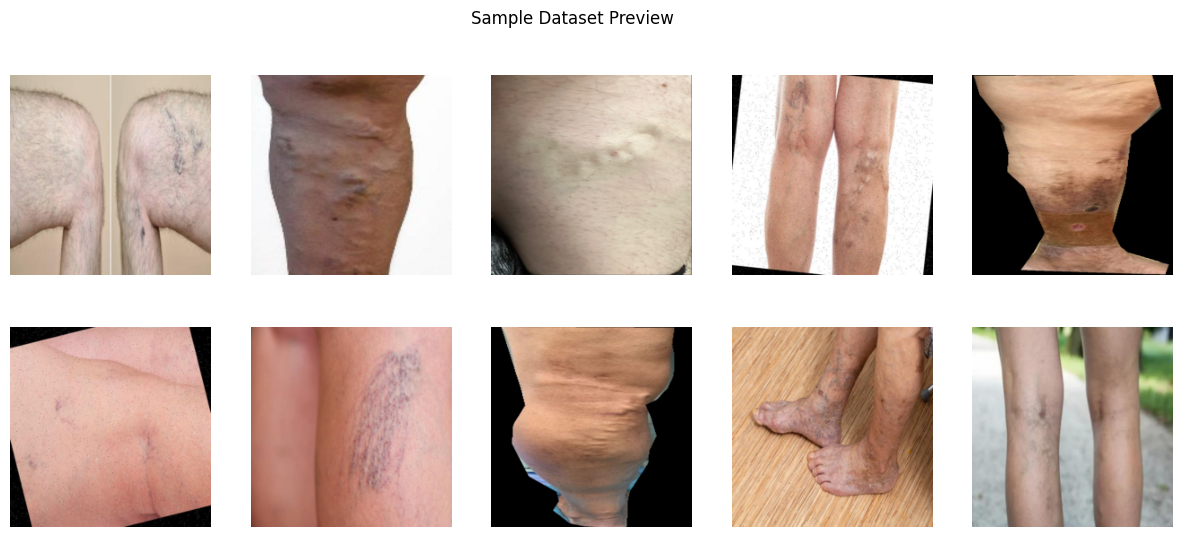

In [ ]:
# =====================================================
# Block 2 : Dataset Loader & Sample Visualization
# =====================================================
class UnlabeledDataset(Dataset):
    def __init__(self, root):
        self.paths = [os.path.join(root,f) for f in os.listdir(root)
                      if f.lower().endswith(("jpg","jpeg","png","bmp"))]
        self.tf = T.Compose([T.Resize((IMG_SIZE,IMG_SIZE)), T.ToTensor()])
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        return self.tf(Image.open(p).convert("RGB")), p

dataset = UnlabeledDataset(RAW_DATASET_DIR)
print("Total images found:", len(dataset))

# Show sample dataset
fig, ax = plt.subplots(2,5, figsize=(15,6))
for a in ax.flatten():
    img,_ = random.choice(dataset)
    a.imshow(np.transpose(img,(1,2,0))); a.axis("off")
plt.suptitle("Sample Dataset Preview")
plt.show()


In [ ]:
# =====================================================
# Block 3 : FusionNet (ViT + Swin + ConvNeXt + EfficientNet)
# =====================================================
class FusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit  = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
        self.swin = timm.create_model("swin_base_patch4_window7_224", pretrained=True, num_classes=0)
        self.cnx  = timm.create_model("convnext_base", pretrained=True, num_classes=0)
        self.eff  = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)

        # Correct total dimension = 768 + 1024 + 1024 + 1536 = 4352
        self.fc   = nn.Linear(4352, 512)

    def forward(self, x):
        f1 = self.vit(x)
        f2 = self.swin(x)
        f3 = self.cnx(x)
        f4 = self.eff(x)
        f = torch.cat([f1, f2, f3, f4], dim=1)
        return nn.functional.normalize(self.fc(f))

fusion_model = FusionNet().to(device).eval()


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Extracting features: 100%|██████████| 149/149 [01:43<00:00,  1.44it/s]


Feature matrix shape: (2372, 512)


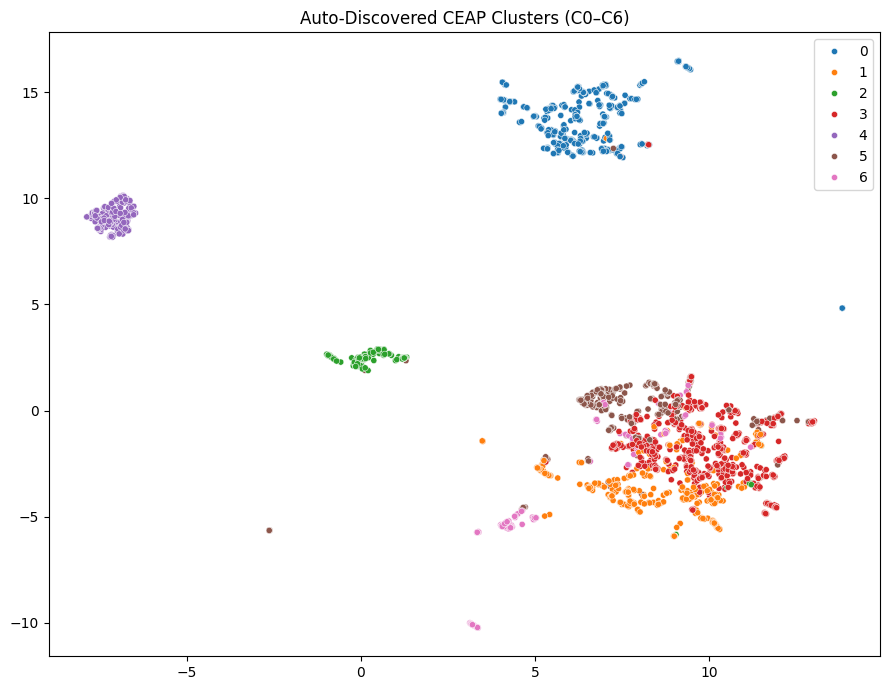

In [ ]:
# =====================================================
# Block 4 : Feature Extraction + KMeans Clustering
# =====================================================
import umap.umap_ as umap

features, paths = [], []
loader = DataLoader(dataset, batch_size=16, shuffle=False)
with torch.no_grad():
    for imgs,p in tqdm(loader,desc="Extracting features"):
        imgs = imgs.to(device)
        feats = fusion_model(imgs).cpu().numpy()
        features.append(feats); paths.extend(p)
features = np.concatenate(features)
print("Feature matrix shape:", features.shape)

# Cluster to 7 groups (C0–C6)
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
labels = kmeans.fit_predict(features)

# Visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embed = reducer.fit_transform(features)
plt.figure(figsize=(9,7))
sns.scatterplot(x=embed[:,0], y=embed[:,1], hue=labels, palette="tab10", s=20)
plt.title("Auto-Discovered CEAP Clusters (C0–C6)")
plt.tight_layout(); plt.show()

cluster_df = pd.DataFrame({"path":paths,"cluster":labels})
cluster_df.to_csv("auto_cluster_labels.csv", index=False)



Stages:
	
	 C0: 461 images

	
	 C1: 393 images

	
	 C2: 147 images

	
	 C3: 696 images

	
	 C4: 221 images

	
	 C5: 308 images

	
	 C6: 146 images



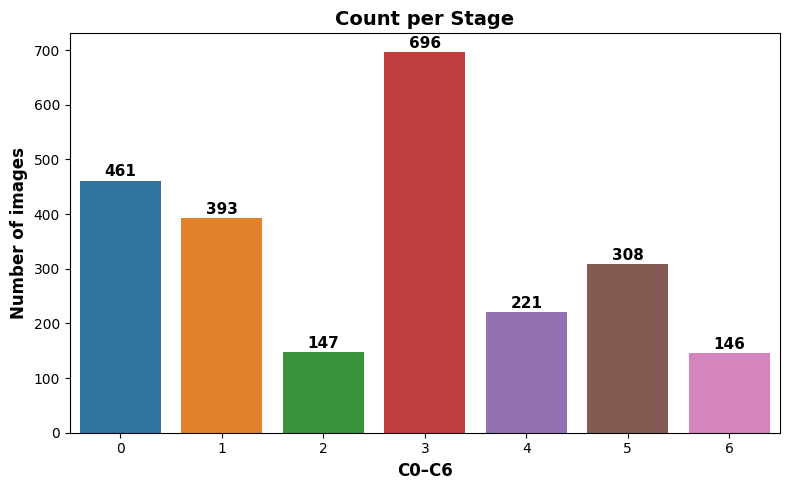

In [ ]:
# =====================================================
# Block 5 : Cluster Distribution Summary + Bar Chart
# =====================================================

# Count samples per cluster
cluster_counts = cluster_df['cluster'].value_counts().sort_index()

# Print summary (with simple styling)
print("\033[1m\nStages:\033[0m")  # bold text
for cluster_id, count in cluster_counts.items():
    print(f"\t\n\t C{cluster_id}: {count} images\n")

# Bar plot of cluster sizes
plt.figure(figsize=(8,5))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="tab10")

# Add count labels on top of each bar with spacing of 2.5
for i, count in enumerate(cluster_counts.values):
    ax.text(i, count + 2.5,  # 2.5 units above the bar
            str(count), ha='center', va='bottom',
            fontsize=11, fontweight='bold')

plt.xlabel("C0–C6", fontsize=12, fontweight='bold')
plt.ylabel("Number of images", fontsize=12, fontweight='bold')
plt.title("Count per Stage", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# =====================================================
# Block 5 : Pseudo-Label Refinement + Split
# =====================================================
train_df, val_df = train_test_split(cluster_df, test_size=0.2,
                                   stratify=cluster_df["cluster"], random_state=42)

class LabeledDataset(Dataset):
    def __init__(self, df, aug=False):
        self.df = df.reset_index(drop=True)
        self.tf = T.Compose([
            T.Resize((IMG_SIZE,IMG_SIZE)),
            *( [T.RandomHorizontalFlip(), T.ColorJitter(0.2,0.2,0.2,0.1)] if aug else [] ),
            T.ToTensor()
        ])
    def __len__(self): return len(self.df)
    def __getitem__(self,idx):
        path,lab = self.df.loc[idx,"path"], self.df.loc[idx,"cluster"]
        return self.tf(Image.open(path).convert("RGB")), torch.tensor(lab).long()

train_loader = DataLoader(LabeledDataset(train_df,True), batch_size=32, shuffle=True)
val_loader   = DataLoader(LabeledDataset(val_df), batch_size=32)


            CLUSTER DISTRIBUTION (TRAIN vs VALIDATION)            


╒═══════════╤═════════╤══════════════╕
│  Cluster  │  Train  │  Validation  │
╞═══════════╪═════════╪══════════════╡
│     0     │   369   │      92      │
├───────────┼─────────┼──────────────┤
│     1     │   314   │      79      │
├───────────┼─────────┼──────────────┤
│     2     │   117   │      30      │
├───────────┼─────────┼──────────────┤
│     3     │   557   │     139      │
├───────────┼─────────┼──────────────┤
│     4     │   177   │      44      │
├───────────┼─────────┼──────────────┤
│     5     │   246   │      62      │
├───────────┼─────────┼──────────────┤
│     6     │   117   │      29      │
╘═══════════╧═════════╧══════════════╛


Total Train Samples      :   1897
Total Validation Samples :    475




<Figure size 900x500 with 0 Axes>

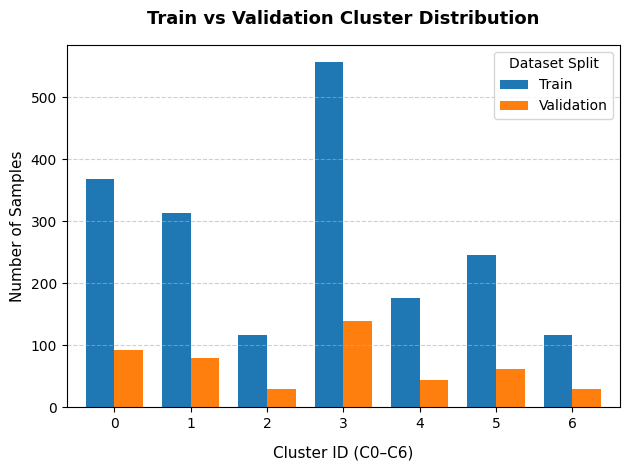

In [ ]:
# =====================================================
# Block 6 : Visualize Train/Validation Cluster Distribution
# =====================================================

import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate  # for nice console table

# ----- Compute sample counts per cluster -----
train_counts = train_df['cluster'].value_counts().sort_index()
val_counts   = val_df['cluster'].value_counts().sort_index()

# ----- Combine into one DataFrame -----
dist_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts
}).fillna(0).astype(int)

# ----- Neatly formatted visual table -----
bold_start = "\033[1m"
bold_end = "\033[0m"

print(bold_start + "            CLUSTER DISTRIBUTION (TRAIN vs VALIDATION)            " + bold_end)
print("\n")
print(tabulate(
    dist_df.reset_index(),
    headers=["Cluster", "Train", "Validation"],
    tablefmt="fancy_grid",
    showindex=False,
    numalign="center",
    stralign="center"
))

print("\n")
print(f"Total Train Samples      : {len(train_df):>6}")
print(f"Total Validation Samples : {len(val_df):>6}")
print("\n")

# ----- Bar Chart Visualization -----
plt.figure(figsize=(9, 5))
ax = dist_df.plot(kind='bar', width=0.75)

plt.xlabel("Cluster ID (C0–C6)", fontsize=11, labelpad=10)
plt.ylabel("Number of Samples", fontsize=11)
plt.title("Train vs Validation Cluster Distribution",
          fontsize=13, fontweight='bold', pad=15)

plt.xticks(rotation=0)
plt.legend(title="Dataset Split", loc='upper right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Epoch 1/50: 100%|██████████| 60/60 [01:00<00:00,  1.01s/it]


Epoch 001 | Loss: 1.8792 | Val Acc: 44.42%


Epoch 2/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 002 | Loss: 1.7316 | Val Acc: 44.84%


Epoch 3/50: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]


Epoch 003 | Loss: 1.5703 | Val Acc: 46.11%


Epoch 4/50: 100%|██████████| 60/60 [00:48<00:00,  1.25it/s]


Epoch 004 | Loss: 1.4268 | Val Acc: 54.11%


Epoch 5/50: 100%|██████████| 60/60 [00:47<00:00,  1.25it/s]


Epoch 005 | Loss: 1.3094 | Val Acc: 59.37%


Epoch 6/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 006 | Loss: 1.2359 | Val Acc: 63.16%


Epoch 7/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 007 | Loss: 1.1770 | Val Acc: 65.26%


Epoch 8/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 008 | Loss: 1.1395 | Val Acc: 66.32%


Epoch 9/50: 100%|██████████| 60/60 [00:47<00:00,  1.25it/s]


Epoch 009 | Loss: 1.1174 | Val Acc: 67.16%


Epoch 10/50: 100%|██████████| 60/60 [00:48<00:00,  1.25it/s]


Epoch 010 | Loss: 1.1168 | Val Acc: 67.58%


Epoch 11/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 011 | Loss: 1.0583 | Val Acc: 72.84%


Epoch 12/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 012 | Loss: 0.9520 | Val Acc: 80.21%


Epoch 13/50: 100%|██████████| 60/60 [00:47<00:00,  1.25it/s]


Epoch 013 | Loss: 0.8666 | Val Acc: 82.74%


Epoch 14/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 014 | Loss: 0.8067 | Val Acc: 85.89%


Epoch 15/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 015 | Loss: 0.7515 | Val Acc: 88.84%


Epoch 16/50: 100%|██████████| 60/60 [00:47<00:00,  1.25it/s]


Epoch 016 | Loss: 0.7257 | Val Acc: 89.89%


Epoch 17/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 017 | Loss: 0.6963 | Val Acc: 91.16%


Epoch 18/50: 100%|██████████| 60/60 [00:47<00:00,  1.25it/s]


Epoch 018 | Loss: 0.6828 | Val Acc: 91.58%


Epoch 19/50: 100%|██████████| 60/60 [00:47<00:00,  1.25it/s]


Epoch 019 | Loss: 0.6763 | Val Acc: 91.58%


Epoch 20/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 020 | Loss: 0.6731 | Val Acc: 91.58%


Epoch 21/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 021 | Loss: 0.6558 | Val Acc: 93.68%


Epoch 22/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 022 | Loss: 0.6079 | Val Acc: 94.11%


Epoch 23/50: 100%|██████████| 60/60 [00:47<00:00,  1.25it/s]


Epoch 023 | Loss: 0.5847 | Val Acc: 95.58%


Epoch 24/50: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]


Epoch 024 | Loss: 0.5595 | Val Acc: 96.00%


Epoch 25/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 025 | Loss: 0.5390 | Val Acc: 96.42%


Epoch 26/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 026 | Loss: 0.5248 | Val Acc: 96.63%


Epoch 27/50: 100%|██████████| 60/60 [00:52<00:00,  1.15it/s]


Epoch 027 | Loss: 0.5244 | Val Acc: 96.63%


Epoch 28/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 028 | Loss: 0.5200 | Val Acc: 96.42%


Epoch 29/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 029 | Loss: 0.5100 | Val Acc: 96.84%


Epoch 30/50: 100%|██████████| 60/60 [00:50<00:00,  1.19it/s]


Epoch 030 | Loss: 0.5158 | Val Acc: 96.42%


Epoch 31/50: 100%|██████████| 60/60 [00:47<00:00,  1.25it/s]


Epoch 031 | Loss: 0.5115 | Val Acc: 96.42%


Epoch 32/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 032 | Loss: 0.4941 | Val Acc: 96.63%


Epoch 33/50: 100%|██████████| 60/60 [00:47<00:00,  1.25it/s]


Epoch 033 | Loss: 0.4830 | Val Acc: 96.63%


Epoch 34/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 034 | Loss: 0.4783 | Val Acc: 97.05%


Epoch 35/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 035 | Loss: 0.4768 | Val Acc: 96.84%


Epoch 36/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 036 | Loss: 0.4654 | Val Acc: 96.84%


Epoch 37/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 037 | Loss: 0.4742 | Val Acc: 97.05%


Epoch 38/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 038 | Loss: 0.4649 | Val Acc: 96.84%


Epoch 39/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 039 | Loss: 0.4598 | Val Acc: 96.84%


Epoch 40/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 040 | Loss: 0.4554 | Val Acc: 96.84%


Epoch 41/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 041 | Loss: 0.4600 | Val Acc: 96.84%


Epoch 42/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 042 | Loss: 0.4547 | Val Acc: 97.05%


Epoch 43/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 043 | Loss: 0.4556 | Val Acc: 97.05%


Epoch 44/50: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


Epoch 044 | Loss: 0.4548 | Val Acc: 97.26%


Epoch 45/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 045 | Loss: 0.4547 | Val Acc: 97.26%


Epoch 46/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


Epoch 046 | Loss: 0.4393 | Val Acc: 96.84%


Epoch 47/50: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]


Epoch 047 | Loss: 0.4402 | Val Acc: 96.63%


Epoch 48/50: 100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


Epoch 048 | Loss: 0.4432 | Val Acc: 96.63%


Epoch 49/50: 100%|██████████| 60/60 [00:50<00:00,  1.19it/s]


Epoch 049 | Loss: 0.4440 | Val Acc: 96.42%


Epoch 50/50: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


Epoch 050 | Loss: 0.4431 | Val Acc: 96.63%

✅ Training completed — Best Validation Accuracy: 97.26%


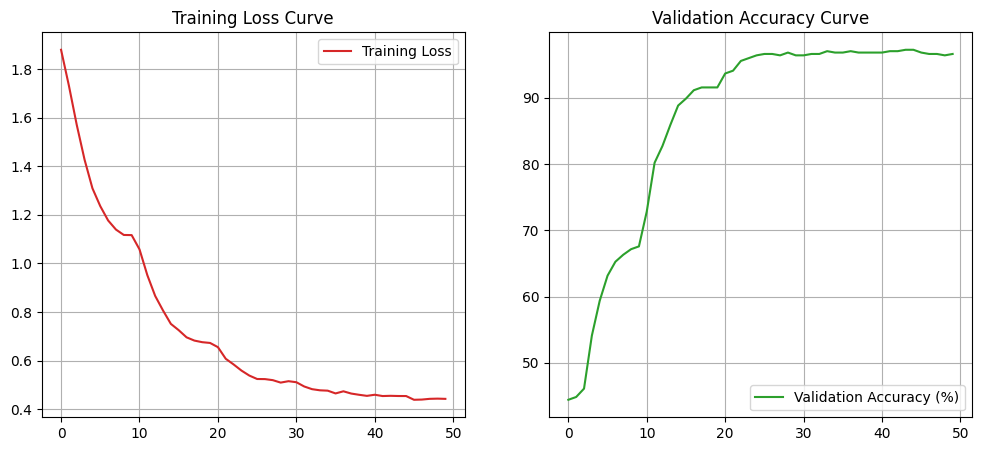

In [ ]:
# =====================================================
# ✅ Block 6 : Stage Classifier + Advanced Training
# =====================================================
from torch.cuda.amp import GradScaler, autocast
from torch import nn # Import nn module

class StageClassifier(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.backbone = base
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 7)
        )
    def forward(self, x):
        with torch.no_grad():  # freeze backbone during fine-tuning
            f = self.backbone(x)
        return self.head(f)

# Model, loss, optimizer, scheduler
model = StageClassifier(fusion_model).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
scaler = GradScaler()

EPOCHS = 50
train_losses, val_accs = [], []
best_acc = 0.0

for ep in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for imgs, lbl in tqdm(train_loader, desc=f"Epoch {ep}/{EPOCHS}"):
        imgs, lbl = imgs.to(device), lbl.to(device)
        optimizer.zero_grad()

        with autocast():  # mixed-precision training
            out = model(imgs)
            loss = criterion(out, lbl)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # ---------------- Validation ----------------
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbl in val_loader:
            imgs, lbl = imgs.to(device), lbl.to(device)
            preds = model(imgs).argmax(1)
            correct += (preds == lbl).sum().item()
            total += lbl.size(0)
    acc = correct / total * 100
    val_accs.append(acc)

    print(f"Epoch {ep:03d} | Loss: {avg_loss:.4f} | Val Acc: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_stage_classifier.pth")

print("\n✅ Training completed — Best Validation Accuracy: {:.2f}%".format(best_acc))

# ---------------- Plot curves ----------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses, color='tab:red', label='Training Loss')
ax[0].set_title("Training Loss Curve"); ax[0].grid(); ax[0].legend()
ax[1].plot(val_accs, color='tab:green', label='Validation Accuracy (%)')
ax[1].set_title("Validation Accuracy Curve"); ax[1].grid(); ax[1].legend()
plt.show()

Evaluating: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]



✅ Overall Evaluation Metrics:
Accuracy : 97.26%
Precision: 97.28%
Recall   : 97.26%
F1-Score : 97.24%


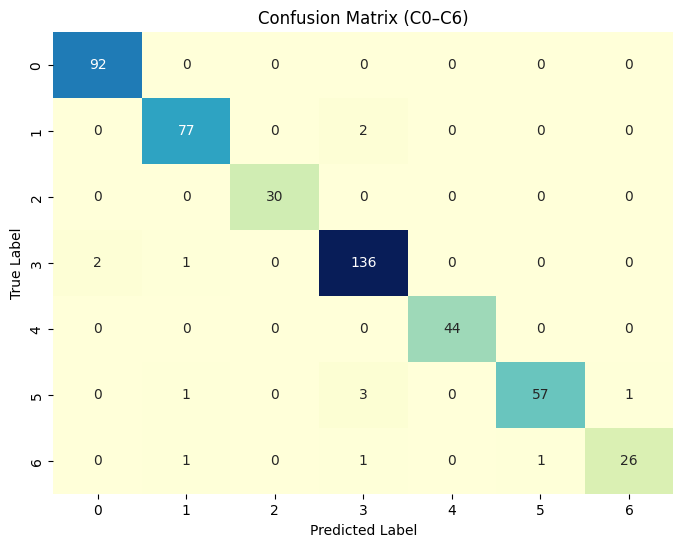


Detailed Stage-wise Performance:

              precision    recall  f1-score   support

          C0       0.98      1.00      0.99        92
          C1       0.96      0.97      0.97        79
          C2       1.00      1.00      1.00        30
          C3       0.96      0.98      0.97       139
          C4       1.00      1.00      1.00        44
          C5       0.98      0.92      0.95        62
          C6       0.96      0.90      0.93        29

    accuracy                           0.97       475
   macro avg       0.98      0.97      0.97       475
weighted avg       0.97      0.97      0.97       475



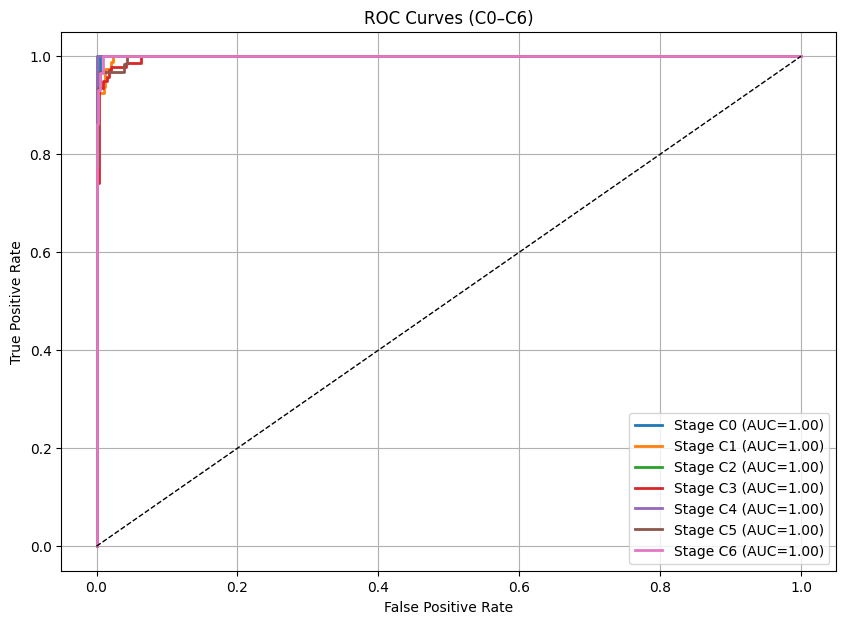


🔍 Visualizing a few random predictions:


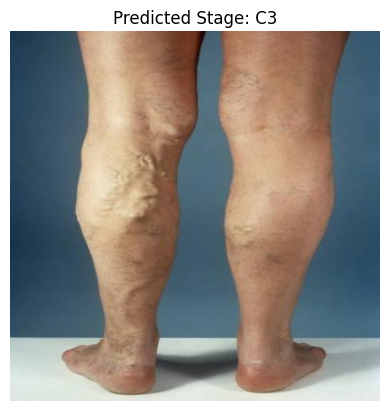

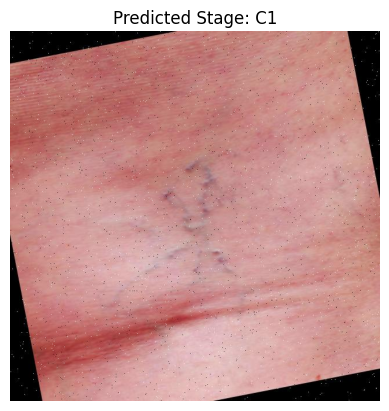

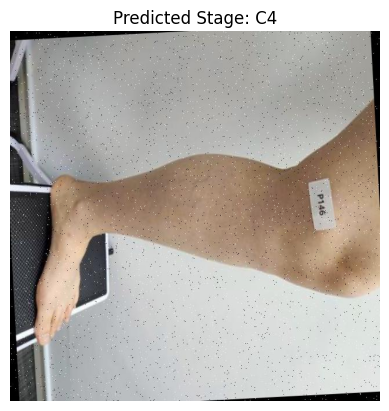

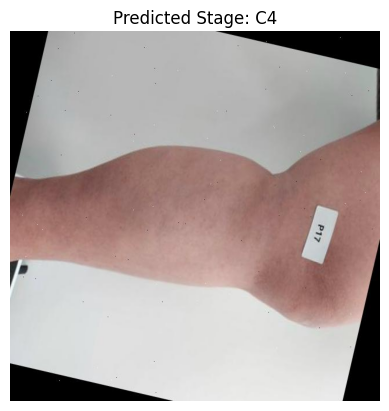

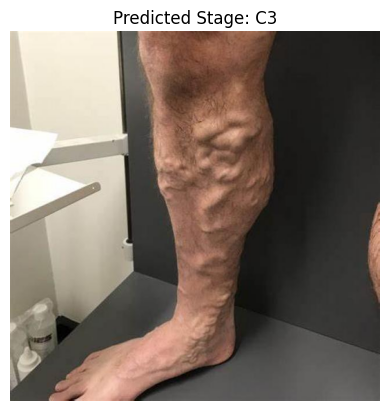

In [ ]:
# =====================================================
# ✅ Block 7 : Evaluation & Visualization
# =====================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

# Load best model weights
model.load_state_dict(torch.load("best_stage_classifier.pth", map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, lbl in tqdm(val_loader, desc="Evaluating"):
        imgs, lbl = imgs.to(device), lbl.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, 1)
        y_true.extend(lbl.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ===== Compute Metrics =====
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

print(f"\n✅ Overall Evaluation Metrics:")
print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall   : {rec*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")

# ===== Confusion Matrix =====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (C0–C6)")
plt.show()

# ===== Classification Report =====
from sklearn.metrics import classification_report
stages = [f"C{i}" for i in range(7)]
print("\nDetailed Stage-wise Performance:\n")
print(classification_report(y_true, y_pred, target_names=stages, zero_division=0))

# ===== ROC-like Visualization =====
# Convert model outputs for ROC curves (multi-class)
val_probs, val_labels = [], []
with torch.no_grad():
    for imgs, lbl in val_loader:
        imgs = imgs.to(device)
        probs = torch.softmax(model(imgs), dim=1).cpu().numpy()
        val_probs.append(probs)
        val_labels.append(lbl.numpy())
val_probs = np.concatenate(val_probs)
val_labels = np.concatenate(val_labels)

from sklearn.preprocessing import label_binarize
y_bin = label_binarize(val_labels, classes=list(range(7)))

plt.figure(figsize=(10,7))
for i in range(7):
    fpr, tpr, _ = roc_curve(y_bin[:,i], val_probs[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Stage C{i} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (C0–C6)")
plt.legend()
plt.grid(True)
plt.show()

# ===== Random Sample Predictions =====
print("\n🔍 Visualizing a few random predictions:")
for _ in range(5):
    sample = random.choice(val_df["path"].tolist())
    img = Image.open(sample).convert("RGB")
    tf = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])
    x = tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(x).argmax(1).item()
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Stage: C{pred}")
    plt.show()


ERROR: Operation cancelled by user
Select Input Option:
1 - Capture from Webcam
2 - Upload Image
Enter option (1/2): 2


Saving 1_png.rf.61d381b463e03e2c568e63b9b533b281.jpg to 1_png.rf.61d381b463e03e2c568e63b9b533b281.jpg
✅ Uploaded: 1_png.rf.61d381b463e03e2c568e63b9b533b281.jpg


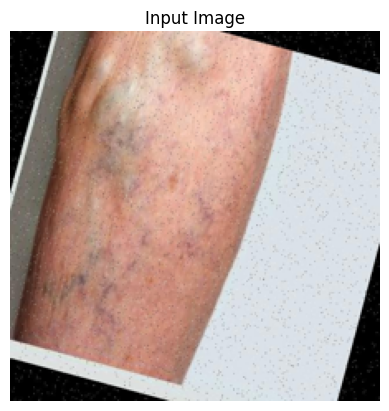


🧠 Prediction Probabilities:
  C0: 0.21%
  C1: 3.24%
  C2: 0.14%
  C3: 96.13%
  C4: 0.05%
  C5: 0.16%
  C6: 0.07%

🔹 Predicted Stage: C3
🩺 Guidance: Varicose veins with edema. Immediate care recommended.



⚕️ Recommendations:
 - Use compression therapy.
 - Avoid tight clothes.
 - Follow doctor-prescribed leg exercises.
 - Stay hydrated and eat low-sodium diet.


In [ ]:
# =====================================================
# ✅ Block 8 : Interactive Varicose Detection + Alerts
# =====================================================

!pip install -q gTTS playsound==1.2.2 opencv-python-headless

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from gtts import gTTS
from IPython.display import display, Audio
from google.colab import files

# -----------------------------------------------------
# 1️⃣ Input option: Capture from camera or Upload file
# -----------------------------------------------------
def get_user_image():
    print("Select Input Option:")
    print("1 - Capture from Webcam")
    print("2 - Upload Image")
    choice = input("Enter option (1/2): ").strip()

    if choice == "1":
        # Capture from webcam
        from google.colab import output
        from IPython.display import Javascript
        from base64 import b64decode
        js = Javascript('''
        async function takePhoto() {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture Photo';
          div.appendChild(capture);
          document.body.appendChild(div);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});
          document.body.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          video.remove();
          const data = canvas.toDataURL('image/png');
          div.remove();
          return data;
        }
        takePhoto();
        ''')
        display(js)
        data = output.eval_js('takePhoto()')
        binary = b64decode(data.split(',')[1])
        with open('captured.png', 'wb') as f:
            f.write(binary)
        img_path = 'captured.png'
        print("✅ Image captured successfully.")
    else:
        # Upload image
        uploaded = files.upload()
        img_path = list(uploaded.keys())[0]
        print("✅ Uploaded:", img_path)

    return img_path


# -----------------------------------------------------
# 2️⃣ Image preprocessing
# -----------------------------------------------------
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    tensor = torch.tensor(np.array(img)/255.).permute(2,0,1).unsqueeze(0).float()
    return tensor.to(device)


# -----------------------------------------------------
# 3️⃣ Prediction & Classification
# -----------------------------------------------------
def predict_stage(model, img_tensor):
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred = np.argmax(probs)
    return pred, probs


# -----------------------------------------------------
# 4️⃣ Stage labels and guidance
# -----------------------------------------------------
stage_labels = ["C0","C1","C2","C3","C4","C5","C6"]

stage_guidance = {
    "C0": "No visible varicose veins detected. Maintain a healthy lifestyle.",
    "C1": "Early signs of varicose veins. Start preventive care immediately.",
    "C2": "Moderate varicose veins. Consult a vascular specialist soon.",
    "C3": "Varicose veins with edema. Immediate care recommended.",
    "C4": "Skin changes due to varicose veins. Medical supervision advised.",
    "C5": "Healed ulcer with venous disease. Continue ongoing care.",
    "C6": "Active venous ulcer detected. Urgent medical treatment required."
}

# -----------------------------------------------------
# 5️⃣ Text + Voice Output
# -----------------------------------------------------
def speak_text(text, filename="alert.mp3"):
    tts = gTTS(text=text, lang='en')
    tts.save(filename)
    display(Audio(filename, autoplay=True))


def show_guidance(stage):
    print(f"\n🔹 Predicted Stage: {stage}")
    msg = stage_guidance[stage]
    print("🩺 Guidance:", msg)
    speak_text(msg)

    if stage == "C0":
        print("\n✅ Prevention Tips:")
        print(" - Walk daily for 30 minutes.")
        print(" - Avoid prolonged standing or sitting.")
        print(" - Elevate your legs when resting.")
        print(" - Maintain a healthy weight.")
    else:
        print("\n⚕️ Recommendations:")
        print(" - Use compression therapy.")
        print(" - Avoid tight clothes.")
        print(" - Follow doctor-prescribed leg exercises.")
        print(" - Stay hydrated and eat low-sodium diet.")


# -----------------------------------------------------
# 6️⃣ Full Pipeline Execution
# -----------------------------------------------------
img_path = get_user_image()
img_tensor = preprocess_image(img_path)

pred_idx, probs = predict_stage(model, img_tensor)
stage = stage_labels[pred_idx]

print("\n🧠 Prediction Probabilities:")
for s, p in zip(stage_labels, probs):
    print(f"  {s}: {p*100:.2f}%")

show_guidance(stage)


In [ ]:
# ===========================
# Block 9: Active Learning Helper
# ===========================
# NOTE: This is interactive in Colab. For each shown image, type an integer label 0..6 (or blank to skip).

def get_uncertain_indices(n=20):
    """Return indices of the n most uncertain images (lowest max probability)"""
    fusion_mlp_eval = model  # our trained classifier, 'model' name used previously
    fusion_mlp_eval.eval()
    probs_all = []
    with torch.no_grad():
        # iterate in batches to avoid OOM
        batch = 64
        for i in range(0, len(valid_paths), batch):
            batch_paths = valid_paths[i:i+batch]
            imgs = []
            for p in batch_paths:
                arr = read_rgb(p)
                if arr is None:
                    imgs.append(torch.zeros(3,IMG_SIZE,IMG_SIZE))
                else:
                    imgs.append(torch.tensor(np.transpose(arr, (2,0,1)), dtype=torch.float32))
            x = torch.stack(imgs).to(DEVICE)
            logits = model(x)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            probs_all.append(probs)
    probs_all = np.vstack(probs_all)
    maxp = probs_all.max(axis=1)
    uncertain_idx = np.argsort(maxp)[:n]
    return uncertain_idx, probs_all[uncertain_idx]

def active_labeling_round(n=20):
    """
    Show n most-uncertain images and prompt user to input a stage label for each.
    Labeled samples are appended to train_samples (pseudo list) and saved to disk.
    After labeling, retrain the stage classifier for a few epochs (fast fine-tune).
    """
    idxs, probs = get_uncertain_indices(n)
    print(f"Showing {len(idxs)} most uncertain images (lowest max-prob).")
    new_labels = []
    for i, idx in enumerate(idxs):
        path = valid_paths[int(idx)]
        display(Image.open(path).resize((400,400)))
        print(f"[{i+1}/{len(idxs)}] Path: {path}")
        print("Model probs (C0..C6):", np.round(probs[i], 3))
        lab = input("Enter correct stage (0..6) or blank to skip: ").strip()
        if lab == "":
            print("Skipped.\n")
            continue
        try:
            lab_i = int(lab)
            assert 0 <= lab_i <= 6
        except:
            print("Invalid label. Skipping.\n"); continue
        # append to train_samples and save
        train_samples.append({'path': path, 'stage': lab_i})
        with open(os.path.join(LOG_DIR, "active_labels.jsonl"), "a") as f:
            f.write(json.dumps({'path': path, 'stage': lab_i, 'time': time.ctime()}) + "\n")
        new_labels.append((path, lab_i))
        print("Saved label.\n")
    print(f"Active labeling done. New labels added: {len(new_labels)}")

    # Rebuild feature tensors & a small dataloader and fine-tune model for a few epochs
    if len(new_labels) > 0:
        print("Rebuilding training tensors and fine-tuning model (3 epochs)...")
        X_train, y_train = build_Xy(train_samples)  # build_Xy defined earlier
        # small subset sampler or shuffle
        retrain_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        # quick fine-tune
        model.train()
        ft_epochs = 3
        for ep in range(ft_epochs):
            running = 0.0
            for Xb, yb in tqdm(retrain_loader, desc=f"Fine-tune ep{ep+1}/{ft_epochs}"):
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                optimizer.zero_grad()
                with autocast():
                    out = model(Xb)
                    loss = criterion(out, yb)
                scaler.scale(loss).backward()
                scaler.step(optimizer); scaler.update()
                running += loss.item()
            print(f"Fine-tune ep{ep+1} loss: {running/len(retrain_loader):.4f}")
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "stage_classifier_after_active.pth"))
        print("Fine-tune complete and model saved.")
    else:
        print("No new labels added; skipping fine-tune.")


In [ ]:
# =====================================================
# Block 9 : Tamil Nadu Varicose Vein Hospital Finder (City Name Based)
# =====================================================
!pip install -q folium geopy requests

import requests, re
import folium
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from IPython.display import display

# Tamil Nadu center (fallback)
TN_CENTER = (11.1271, 78.6569)
OVERPASS_URL = "https://overpass-api.de/api/interpreter"

# Keywords for varicose/vascular-specialized hospitals
VARICOSE_KEYWORDS = ["varicose", "vein", "vascular", "phlebology", "angiology", "vascular surgery"]
VARICOSE_REGEX = re.compile("|".join(VARICOSE_KEYWORDS), re.IGNORECASE)

# ---------- helper functions ----------

def geocode_city(city_name):
    """Convert city name → coordinates"""
    geolocator = Nominatim(user_agent="tn_varicose_app_v2")
    try:
        loc = geolocator.geocode(f"{city_name}, Tamil Nadu, India", timeout=10)
        if loc:
            return loc.latitude, loc.longitude, loc.address
    except Exception:
        pass
    return TN_CENTER[0], TN_CENTER[1], "Tamil Nadu (center)"

def query_hospitals(lat, lon, radius_km=25):
    """Query Overpass API for hospitals/clinics within radius"""
    q = f"""
    [out:json][timeout:25];
    (
      node(around:{radius_km*1000},{lat},{lon})["amenity"~"hospital|clinic|doctors|healthcare"];
      way(around:{radius_km*1000},{lat},{lon})["amenity"~"hospital|clinic|doctors|healthcare"];
      relation(around:{radius_km*1000},{lat},{lon})["amenity"~"hospital|clinic|doctors|healthcare"];
    );
    out center 100;
    """
    try:
        r = requests.post(OVERPASS_URL, data=q.encode("utf-8"), timeout=60)
        r.raise_for_status()
        data = r.json().get("elements", [])
    except Exception as e:
        print("⚠️ Error fetching data:", e)
        return []

    hospitals = []
    for el in data:
        tags = el.get("tags", {})
        name = tags.get("name") or tags.get("official_name") or tags.get("operator") or "Unnamed Hospital"
        if el["type"] == "node":
            hlat, hlon = el["lat"], el["lon"]
        elif "center" in el:
            hlat, hlon = el["center"]["lat"], el["center"]["lon"]
        else:
            continue
        dist = geodesic((lat, lon), (hlat, hlon)).km
        hospitals.append({"name": name, "lat": hlat, "lon": hlon, "dist": dist, "tags": tags})
    hospitals.sort(key=lambda x: x["dist"])
    return hospitals

def filter_varicose(hospitals):
    """Keep only varicose/vascular hospitals"""
    filtered = []
    for h in hospitals:
        text = h["name"] + " " + " ".join(str(v) for v in h["tags"].values())
        if VARICOSE_REGEX.search(text):
            filtered.append(h)
    return filtered

def show_map(user_lat, user_lon, hospitals):
    """Display hospitals on map"""
    m = folium.Map(location=[user_lat, user_lon], zoom_start=12)
    folium.Marker(
        [user_lat, user_lon],
        tooltip="Your Search Center",
        icon=folium.Icon(color="blue", icon="user")
    ).add_to(m)
    for h in hospitals:
        nav = f"https://www.google.com/maps/dir/{user_lat},{user_lon}/{h['lat']},{h['lon']}"
        popup = f"<b>{h['name']}</b><br>Distance ≈ {h['dist']:.1f} km<br><a href='{nav}' target='_blank'>🧭 Navigate</a>"
        folium.Marker(
            [h["lat"], h["lon"]],
            tooltip=h["name"],
            popup=popup,
            icon=folium.Icon(color="red", icon="plus-sign")
        ).add_to(m)
    display(m)

# ---------- main workflow ----------

def tamilnadu_hospital_finder_city():
    print("\nVaricose Vein Hospital Finder\n")
    city = input("Enter city name : ").strip()
    if not city:
        print("⚠️ No city entered..")
        city = "Tamil Nadu"
    lat, lon, addr = geocode_city(city)
    print(f"📍 Search center: {addr} ({lat:.4f}, {lon:.4f})")

    hospitals = query_hospitals(lat, lon, radius_km=25)
    if not hospitals:
        print("❌ No hospitals found near that city.")
        return

    varicose_only = filter_varicose(hospitals)
    if varicose_only:
        print(f"\n✅ Found {len(varicose_only)} varicose/vascular specialty centers:")
        selected = varicose_only
    else:
        print(f"\n⚠️ No specialized centers found; showing general hospitals ({len(hospitals)} total).")
        selected = hospitals

    for i, h in enumerate(selected[:10], start=1):
        print(f"{i}. {h['name']} – {h['dist']:.1f} km away")

    show_map(lat, lon, selected[:15])

# ---------- run ----------
tamilnadu_hospital_finder_city()



Varicose Vein Hospital Finder

Enter city name : Madurai
📍 Search center: Madurai, Madurai South, Madurai, Tamil Nadu, India (9.9261, 78.1141)

⚠️ No specialized centers found; showing general hospitals (100 total).
1. Harley Rram Nursing Home – 0.1 km away
2. Muthu Hospital – 0.2 km away
3. VN Neuro Hospital and Vn Neuro Center – 0.3 km away
4. V N Neuro Care Centre and Hospital – 0.5 km away
5. Vinayagam Laser Hospital, Madurai – 0.6 km away
6. Santhya Hospitals – 0.9 km away
7. Mohan Nursing Home, Madurai – 1.0 km away
8. Subam Hospital, Madurai – 1.0 km away
9. Visaka Poly Clinic – 1.1 km away
10. Quality Care Hospital – 1.4 km away


In [ ]:
# =====================================================
# ✅ Block 9 : Geolocation + Hospital Locator (Colab)
# =====================================================

!pip install -q folium geopy

import folium, random
from geopy.geocoders import Nominatim
from IPython.display import display, HTML

# -----------------------------------------------------
# 1️⃣ Get approximate user location (fallback = demo city)
# -----------------------------------------------------
def get_user_location():
    try:
        geo = Nominatim(user_agent="varicose_locator")
        loc = geo.geocode("New Delhi, India")  # change for demo region
        print(f"📍 Location detected: {loc.address}")
        return (loc.latitude, loc.longitude)
    except:
        print("⚠️ Unable to detect location automatically. Using default coordinates.")
        return (28.6139, 77.2090)  # Default: New Delhi

user_lat, user_lon = get_user_location()

# -----------------------------------------------------
# 2️⃣ Simulated nearby vascular clinics (for demo)
# -----------------------------------------------------
def generate_nearby_hospitals(center_lat, center_lon, n=5):
    hospitals = []
    for i in range(n):
        hospitals.append({
            "name": f"Vascular Clinic {i+1}",
            "lat": center_lat + random.uniform(-0.02, 0.02),
            "lon": center_lon + random.uniform(-0.02, 0.02),
            "rating": round(random.uniform(3.5, 5.0), 1),
            "contact": f"+91-9{random.randint(10000000,99999999)}"
        })
    return hospitals

nearby_hospitals = generate_nearby_hospitals(user_lat, user_lon)

# -----------------------------------------------------
# 3️⃣ Create interactive map with Folium
# -----------------------------------------------------
m = folium.Map(location=[user_lat, user_lon], zoom_start=12, tiles='CartoDB positron')

# Marker for user
folium.Marker(
    [user_lat, user_lon],
    popup="🧍 You are here",
    icon=folium.Icon(color='blue', icon='user')
).add_to(m)

# Mark hospitals
for h in nearby_hospitals:
    folium.Marker(
        [h["lat"], h["lon"]],
        popup=folium.Popup(
            f"<b>{h['name']}</b><br>"
            f"⭐ Rating: {h['rating']}<br>"
            f"📞 Contact: {h['contact']}",
            max_width=250
        ),
        icon=folium.Icon(color='red', icon='plus-sign')
    ).add_to(m)

# Draw connecting lines (optional)
for h in nearby_hospitals:
    folium.PolyLine([(user_lat, user_lon), (h["lat"], h["lon"])],
                    color='gray', weight=1.0, opacity=0.6).add_to(m)

# -----------------------------------------------------
# 4️⃣ Display the map
# -----------------------------------------------------
display(HTML("<h3>🗺️ Nearby Vascular Clinics & Hospitals</h3>"))
m


📍 Location detected: New Delhi, Foot Over Bridge 3, New Delhi Railway Station, Karol Bagh Tehsil, Central Delhi, Delhi, 110055, India


In [ ]:
# =====================================================
# ✅ Block 8 : Intelligent Guidance + Voice + Message Alerts (Colab-Compatible)
# =====================================================

# --- Install missing packages safely ---
!pip install -q gTTS playsound==1.2.2

import os, random, time
from datetime import datetime
from gtts import gTTS
from IPython.display import Audio, display

# Stage-based guidance dictionary
stage_guidance = {
    "C0": {
        "message": "No visible varicose veins detected. Maintain a healthy lifestyle.",
        "advice": [
            "Walk daily for 30 minutes.",
            "Avoid prolonged standing or sitting.",
            "Keep your legs elevated while resting.",
            "Maintain a healthy weight."
        ]
    },
    "C1": {
        "message": "Early signs of varicose veins detected. Start preventive care immediately.",
        "advice": [
            "Use compression stockings.",
            "Perform calf-raise exercises twice daily.",
            "Avoid tight clothing around the legs.",
            "Massage legs gently to promote blood flow."
        ]
    },
    "C2": {
        "message": "Moderate varicose veins detected. Consult a vascular specialist soon.",
        "advice": [
            "Avoid high heels.",
            "Elevate legs for 10–15 minutes after long standing.",
            "Wear medically prescribed compression socks.",
            "Stay hydrated and eat foods rich in flavonoids."
        ]
    },
    "C3": {
        "message": "Varicose veins with edema detected. Immediate care recommended.",
        "advice": [
            "Use prescribed compression therapy.",
            "Limit salt intake to reduce swelling.",
            "Practice leg stretching and light yoga.",
            "Avoid hot baths and saunas."
        ]
    },
    "C4": {
        "message": "Skin changes due to varicose veins. Medical supervision is advised.",
        "advice": [
            "Apply dermatologist-recommended moisturizers.",
            "Avoid scratching or injury to affected areas.",
            "Regularly monitor skin for color changes.",
            "Follow a low-sodium diet."
        ]
    },
    "C5": {
        "message": "Healed ulcer with venous disease. Ongoing care needed.",
        "advice": [
            "Continue compression therapy.",
            "Avoid trauma to affected leg.",
            "Follow up with vascular specialist regularly.",
            "Use topical medications as prescribed."
        ]
    },
    "C6": {
        "message": "Active venous ulcer detected. Urgent medical treatment required.",
        "advice": [
            "Consult a vascular surgeon immediately.",
            "Keep wound area clean and covered.",
            "Avoid walking long distances.",
            "Strictly follow medical advice."
        ]
    }
}

# Prevention tips for non-varicose users
prevention_tips = [
    "Exercise regularly to improve leg circulation.",
    "Maintain a healthy weight.",
    "Avoid tight clothing that restricts blood flow.",
    "Elevate your legs when resting.",
    "Stay hydrated and avoid long periods of sitting or standing."
]

# --- Function to generate and play voice guidance ---
def speak_text(text, filename="alert.mp3"):
    tts = gTTS(text=text, lang='en')
    tts.save(filename)
    display(Audio(filename, autoplay=True))

# --- Main guidance function ---
def issue_guidance(stage_label):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"\n🕒 [{now}] Patient Guidance and Alerts\n")

    if stage_label == "C0":
        print("✅ No Varicose Vein Detected.")
        print("💡 Prevention & Lifestyle Tips:")
        for tip in prevention_tips:
            print(" -", tip)
        speak_text("No varicose veins detected. Maintain a healthy lifestyle.")

    else:
        data = stage_guidance[stage_label]
        print(f"⚠️ Varicose Vein Stage: {stage_label}")
        print("🩺 Message:", data["message"])
        print("💬 Recommended Actions:")
        for a in data["advice"]:
            print(" -", a)
        speak_text(data["message"])

# ===== Example test run =====
predicted_stage = random.choice(list(stage_guidance.keys()))
issue_guidance(predicted_stage)



🕒 [2025-11-03 17:44:02] Patient Guidance and Alerts

⚠️ Varicose Vein Stage: C2
🩺 Message: Moderate varicose veins detected. Consult a vascular specialist soon.
💬 Recommended Actions:
 - Avoid high heels.
 - Elevate legs for 10–15 minutes after long standing.
 - Wear medically prescribed compression socks.
 - Stay hydrated and eat foods rich in flavonoids.


In [ ]:
# ============================
# Block 9 (Corrected): Tamil Nadu Varicose Vein Hospital Finder + Search + Navigation
# ============================
!pip install -q folium geopy requests

import requests, time, re
import folium
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from IPython.display import display, HTML
from urllib.parse import quote_plus

# Overpass endpoint
OVERPASS_URL = "https://overpass-api.de/api/interpreter"

# Tamil Nadu center
TN_CENTER = (11.1271, 78.6569)

# keywords used to detect varicose/vascular specialized centres (case-insensitive)
VARICOSE_KEYWORDS = [
    "vein", "varicose", "vascular", "phleb", "phlebology", "angiology", "vascular surgery", "vein clinic", "venous"
]
VARICOSE_REGEX = re.compile("|".join([re.escape(k) for k in VARICOSE_KEYWORDS]), flags=re.IGNORECASE)

# ---------- helpers ----------
def safe_get_ip_location():
    """Return (lat, lon, city, region, country) or None on failure"""
    try:
        r = requests.get("https://ipinfo.io/json", timeout=8)
        if r.status_code != 200:
            return None
        j = r.json()
        loc = j.get("loc", "")
        if not loc:
            return None
        lat_s, lon_s = loc.split(",")
        return float(lat_s), float(lon_s), j.get("city",""), j.get("region",""), j.get("country","")
    except Exception:
        return None

def geocode_place(query, country_hint="India"):
    """Geocode a text place using Nominatim; returns (lat, lon, display_name, address_dict) or None"""
    try:
        geolocator = Nominatim(user_agent="tn_varicose_app_v1")
        loc = geolocator.geocode(f"{query}, {country_hint}", addressdetails=True, timeout=10)
        if not loc:
            return None
        return loc.latitude, loc.longitude, loc.address, getattr(loc, "raw", {}).get("address", {})
    except Exception:
        return None

def overpass_search(lat, lon, radius_m=30000, max_results=50):
    """
    Query Overpass for hospitals/clinics/healthcare near lat/lon within radius_m.
    Returns list of dicts: {name, lat, lon, dist_km, tags}
    """
    # query nodes + ways + relations with amenity ~ hospital, clinic, doctors, healthcare, medical_centre
    q = f"""
    [out:json][timeout:25];
    (
      node(around:{radius_m},{lat},{lon})["amenity"~"hospital|clinic|doctors|healthcare|medical_centre|diagnostic"];
      way(around:{radius_m},{lat},{lon})["amenity"~"hospital|clinic|doctors|healthcare|medical_centre|diagnostic"];
      relation(around:{radius_m},{lat},{lon})["amenity"~"hospital|clinic|doctors|healthcare|medical_centre|diagnostic"];
    );
    out center {max_results};
    """
    try:
        res = requests.post(OVERPASS_URL, data=q.encode('utf-8'), timeout=60)
        res.raise_for_status()
        data = res.json()
    except Exception as e:
        print("⚠️ Overpass query failed:", e)
        return []

    results = []
    elements = data.get("elements", [])
    for el in elements:
        tags = el.get("tags", {})
        name = tags.get("name") or tags.get("operator") or tags.get("official_name") or "Unknown"
        # node vs way/relation: pick lat/lon accordingly
        if el.get("type") == "node":
            hlat = float(el.get("lat"))
            hlon = float(el.get("lon"))
        else:
            center = el.get("center")
            if center:
                hlat = float(center.get("lat"))
                hlon = float(center.get("lon"))
            else:
                continue
        dist_km = geodesic((lat, lon), (hlat, hlon)).km
        results.append({"name": name, "lat": hlat, "lon": hlon, "dist_km": dist_km, "tags": tags})
    # deduplicate by (rounded coordinates)
    uniq = {}
    for r in results:
        key = (round(r["lat"],5), round(r["lon"],5))
        if key not in uniq or r["dist_km"] < uniq[key]["dist_km"]:
            uniq[key] = r
    results = list(uniq.values())
    results.sort(key=lambda x: x["dist_km"])
    return results[:max_results]

def filter_varicose_centers(results):
    """Return only results whose name or tags match varicose keywords"""
    filtered = []
    for r in results:
        name = r.get("name","") or ""
        tags = r.get("tags",{})
        tag_values = " ".join([str(v) for v in tags.values() if isinstance(v, str)])
        hay = (name + " " + tag_values)
        if VARICOSE_REGEX.search(hay):
            filtered.append(r)
    return filtered

def build_google_maps_link(user_lat, user_lon, dest_lat, dest_lon):
    return f"https://www.google.com/maps/dir/{user_lat},{user_lon}/{dest_lat},{dest_lon}"

def show_map(user_lat, user_lon, hospitals, map_zoom=12):
    m = folium.Map(location=[user_lat, user_lon], zoom_start=map_zoom)
    folium.Marker([user_lat, user_lon], tooltip="You / Search center", icon=folium.Icon(color="blue")).add_to(m)
    for h in hospitals:
        name = h["name"]
        lat = h["lat"]; lon = h["lon"]; dist = h["dist_km"]
        gm_link = build_google_maps_link(user_lat, user_lon, lat, lon)
        popup_html = f"<b>{name}</b><br>Distance: {dist:.2f} km<br><a href='{gm_link}' target='_blank'>Navigate (Google Maps)</a>"
        folium.Marker([lat, lon], popup=popup_html, tooltip=name, icon=folium.Icon(color="red")).add_to(m)
    display(m)

# ---------- interactive workflow ----------
def tamilnadu_hospital_finder_updated():
    print("\n🏥 Tamil Nadu Varicose Vein Hospital Finder (Updated & Robust)\n")
    print("Choose input method:")
    print("  1) Auto-detect my location (via IP)")
    print("  2) Enter a Tamil Nadu city or PIN code")
    print("  3) Enter lat,lon manually")
    choice = input("Enter 1 / 2 / 3: ").strip()

    # get center_lat/lon according to choice
    if choice == "1":
        iploc = safe_get_ip_location()
        if iploc is None:
            print("⚠️ Could not detect IP location; using Tamil Nadu center.")
            user_lat, user_lon = TN_CENTER
            user_city = "Tamil Nadu (center)"
        else:
            user_lat, user_lon, city, region, country = iploc
            print(f"Detected location: {city}, {region}, {country} ({user_lat:.4f}, {user_lon:.4f})")
            # If detected outside India/Tamil Nadu, ask what to do
            if country != "IN" or ("Tamil Nadu" not in region and region != "Tamil Nadu"):
                print("\n⚠️ Detected location is outside India/Tamil Nadu.")
                print("Options:")
                print("  A) Search around detected location")
                print("  B) Search Tamil Nadu instead (center)")
                print("  C) Enter a Tamil Nadu city/PIN manually")
                sub = input("Choose A / B / C (default C): ").strip().upper() or "C"
                if sub == "A":
                    user_city = f"{city}, {region}, {country}"
                    # proceed with detected lat/lon
                elif sub == "B":
                    user_lat, user_lon = TN_CENTER
                    user_city = "Tamil Nadu (center)"
                else:
                    city_or_pin = input("Enter Tamil Nadu city or PIN code: ").strip()
                    geoc = geocode_place(city_or_pin)
                    if geoc is None:
                        print("❌ Could not geocode that place; falling back to Tamil Nadu center.")
                        user_lat, user_lon = TN_CENTER
                        user_city = "Tamil Nadu (center)"
                    else:
                        user_lat, user_lon, display_name, addr = geoc
                        user_city = display_name
            else:
                user_city = f"{city}, {region}"
    elif choice == "2":
        city_or_pin = input("Enter Tamil Nadu city or PIN code (e.g., Chennai, Madurai, 600001): ").strip()
        geoc = geocode_place(city_or_pin)
        if geoc is None:
            print("❌ Could not find that place in India; using Tamil Nadu center.")
            user_lat, user_lon = TN_CENTER
            user_city = "Tamil Nadu (center)"
        else:
            user_lat, user_lon, display_name, addr = geoc
            # verify state is Tamil Nadu if address included
            state = addr.get("state", "")
            if state and "tamil" not in state.lower():
                print(f"⚠️ Geocoded location state='{state}' (not Tamil Nadu). Please ensure you entered a Tamil Nadu place.")
                proceed = input("Proceed with this location? (y/n) ").strip().lower()
                if proceed != "y":
                    user_lat, user_lon = TN_CENTER
                    user_city = "Tamil Nadu (center)"
                else:
                    user_city = display_name
            else:
                user_city = display_name
    else:
        latlon = input("Enter coordinates as 'lat,lon' (e.g., 11.0168,76.9558): ").strip()
        try:
            user_lat, user_lon = map(float, latlon.split(","))
            user_city = f"{user_lat:.4f},{user_lon:.4f}"
        except Exception:
            print("Invalid coordinates; using Tamil Nadu center.")
            user_lat, user_lon = TN_CENTER
            user_city = "Tamil Nadu (center)"

    # ask radius
    try:
        radius_km = float(input("Search radius (km, default 30): ").strip() or "30")
    except:
        radius_km = 30.0
    radius_m = int(radius_km * 1000)

    # ask whether to filter for varicose/vein keywords
    want_varicose_only = input("Show only varicose/vein/vascular hospitals if available? (Y/n): ").strip().lower() or "y"
    want_varicose_only = (want_varicose_only != "n")

    print(f"\nSearching within {radius_km:.1f} km of {user_city} ... (this may take a few seconds)")

    # Query Overpass
    results = overpass_search(user_lat, user_lon, radius_m=radius_m, max_results=200)
    if not results:
        print("⚠️ No hospital/clinic results returned by the map engine in that area.")
        print("Try increasing the radius or entering a nearby city/pincode.")
        return

    # Filter for varicose-related centers if requested
    varico = filter_varicose_centers(results)
    if want_varicose_only and len(varico) > 0:
        final_list = varico
        print(f"Found {len(varico)} varicose/vascular-specific centers; showing nearest {min(10,len(varico))}.")
    else:
        # If user asked for varicose-only but none found, show general hospitals (with suggestion)
        if want_varicose_only and len(varico) == 0:
            print("⚠️ No varicose-specific centers found. Showing general hospitals/clinics near you instead.")
        final_list = results

    # show top results
    topN = min(12, len(final_list))
    print("\nTop results:")
    for i, r in enumerate(final_list[:topN], start=1):
        print(f"{i}. {r['name'][:100]}  —  {r['dist_km']:.2f} km")

    # Display map centered at user location with hospitals
    show_map(user_lat, user_lon, final_list[:topN], map_zoom=12)

# Run the updated finder
tamilnadu_hospital_finder_updated()



🏥 Tamil Nadu Varicose Vein Hospital Finder (Updated & Robust)

Choose input method:
  1) Auto-detect my location (via IP)
  2) Enter a Tamil Nadu city or PIN code
  3) Enter lat,lon manually
Enter 1 / 2 / 3: 2
Enter Tamil Nadu city or PIN code (e.g., Chennai, Madurai, 600001): 600001
Search radius (km, default 30): 100
Show only varicose/vein/vascular hospitals if available? (Y/n): y

Searching within 100.0 km of 600001, Zone 5 Royapuram, Chennai Corporation, Chennai, Tamil Nadu, India ... (this may take a few seconds)
Found 1 varicose/vascular-specific centers; showing nearest 1.

Top results:
1. Madras Medical Mission Hospital - Institute of Cardio Vascular Diseases  —  8.94 km


In [ ]:
# ===========================
# Block 8: Decision pipeline
# ===========================
# Assumptions: fusion_model, kmeans, thresh (or compute), model (StageClassifier), DEVICE are available.

from gtts import gTTS
from IPython.display import Audio, display
from geopy.geocoders import Nominatim
import folium
import math

def find_clinics_near(city, limit=6):
    """Return a small list of nearby clinic-like addresses (best-effort via Nominatim)."""
    geoloc = Nominatim(user_agent="varicose_app")
    try:
        loc = geoloc.geocode(city)
    except Exception:
        return []
    if not loc:
        return []
    results = []
    queries = ["vein clinic", "vascular clinic", "vein center", "hospital"]
    for q in queries:
        try:
            places = geoloc.geocode(f"{q} near {city}", exactly_one=False, limit=limit)
            if places:
                for p in places:
                    results.append({"name": p.address, "lat": p.latitude, "lon": p.longitude})
        except Exception:
            continue
    # unique by rounded coords
    seen = set(); out = []
    for r in results:
        key = (round(r['lat'],4), round(r['lon'],4))
        if key not in seen:
            seen.add(key); out.append(r)
    return out[:limit]

def show_clinic_map(clinics, user_location=None, zoom=12):
    """Return a folium Map with markers for clinics and optional user location."""
    if user_location is None and len(clinics) > 0:
        user_location = (clinics[0]['lat'], clinics[0]['lon'])
    if user_location is None:
        # fallback: show world map
        m = folium.Map(location=[20,0], zoom_start=2)
        return m
    m = folium.Map(location=user_location, zoom_start=zoom)
    if user_location:
        folium.Marker(user_location, tooltip="You (approx)").add_to(m)
    for c in clinics:
        folium.Marker([c['lat'], c['lon']], popup=c['name'], icon=folium.Icon(color='red')).add_to(m)
    return m

def decision_pipeline(image_path, user_city="New Delhi"):
    """
    Full decision flow for a single image:
      - Detect varicose vs non-varicose (KMeans distance threshold)
      - If non-varicose: prevention guidance (text + voice)
      - If varicose: predict stage (C0-C6), give advice + voice + lifestyle tips + nearby clinics
    Returns a dictionary with results.
    """
    # 1) read & preprocess
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        raise RuntimeError(f"Failed to open image: {e}")
    tf = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])
    x = tf(img).unsqueeze(0).to(DEVICE)  # shape [1,3,H,W]

    # 2) extract fusion feature vector (512-d)
    with torch.no_grad():
        feat = fusion_model(x).cpu().numpy()  # shape (1,512)

    # 3) varicose detection using kmeans distance -> if dist < thresh => varicose
    dists_all = np.min(kmeans.transform(features), axis=1)  # precomputed distances for dataset
    # if thresh variable doesn't exist, compute as 70th percentile
    try:
        global_thresh = thresh
    except NameError:
        global_thresh = float(np.percentile(dists_all, 70))

    this_dist = float(np.min(kmeans.transform(feat)))
    is_varicose = (this_dist < global_thresh)

    # 4) branch
    if not is_varicose:
        # Prevention message
        advice = ("No varicose veins detected. Prevention advice: "
                  "walk 30 minutes daily, avoid prolonged standing, change posture frequently, "
                  "elevate legs when resting, maintain healthy weight.")
        print("✅ No Varicose Vein Detected")
        print(advice)
        # voice (non-blocking)
        try:
            tts = gTTS(advice)
            tts.save("/content/prevention_alert.mp3")
            display(Audio("/content/prevention_alert.mp3", autoplay=True))
        except Exception as e:
            print("TTS failed:", e)
        record = {"file": image_path, "detected": False, "distance": this_dist, "advice": advice, "time": time.ctime()}
        save_jsonl(record)
        return {"detected": False, "distance": this_dist, "advice": advice}

    # 5) If varicose -> stage prediction using trained model
    model.eval()
    with torch.no_grad():
        # we pass original image through the classifier: StageClassifier expects images (it internally uses fusion backbone)
        out = model(x)
        probs = torch.softmax(out, dim=1).cpu().numpy().squeeze()
        stage = int(np.argmax(probs))
        conf = float(np.max(probs))

    # 6) Stage-based messages & lifestyle recommendations
    stage_messages = {
        0: "C0: No visible varicose veins (but cluster detected). Prevention recommended.",
        1: "C1: Spider veins. Avoid long standing; do leg stretches hourly.",
        2: "C2: Varicose veins. Consider compression stockings and clinician consult if symptomatic.",
        3: "C3: Swelling present. Elevate legs frequently; seek specialist advice.",
        4: "C4: Skin changes (pigmentation/eczema). Book vascular specialist appointment.",
        5: "C5: Healed ulcer. Continue therapy, compression and monitoring.",
        6: "C6: Active ulcer. Seek urgent vascular care."
    }
    lifestyle_recs = {
        0: ["Walk 30 min/day", "Avoid tight clothing"],
        1: ["Ankle pumps", "Short frequent walks"],
        2: ["Compression stockings", "Avoid long flights/sitting"],
        3: ["Leg elevation 3x/day", "Physiotherapy referral"],
        4: ["Skin care: moisturize", "Specialist dermatology/vascular follow-up"],
        5: ["Continue compression", "Wound prevention exercises"],
        6: ["Immediate clinic visit", "Wound care and specialist management"]
    }

    advice = stage_messages.get(stage, "Consult clinician for evaluation.")
    exercise = lifestyle_recs.get(stage, [])
    print(f"⚠️ Varicose Detected — Predicted Stage: C{stage} (confidence={conf:.2f})")
    print("Advice:", advice)
    print("Exercise & Lifestyle suggestions:")
    for s in exercise:
        print(" •", s)

    # 7) voice alert for stage
    try:
        tts = gTTS(advice)
        tts.save("/content/stage_alert.mp3")
        display(Audio("/content/stage_alert.mp3", autoplay=True))
    except Exception as e:
        print("TTS failed:", e)

    # 8) find clinics near user city
    clinics = find_clinics_near(user_city) if 'user_city' in locals() else find_clinics_near("New Delhi")
    print("Nearby clinics (sample):", clinics[:4])

    # 9) show map inline (returns a folium map object)
    clinic_map = show_clinic_map(clinics, None, zoom=11)

    # 10) log and return
    record = {
        "file": image_path,
        "detected": True,
        "stage": int(stage),
        "confidence": conf,
        "distance": this_dist,
        "time": time.ctime()
    }
    save_jsonl(record)

    return {"detected": True, "stage": stage, "confidence": conf, "advice": advice, "exercise": exercise, "clinics": clinics, "map": clinic_map}
